# Home assignment 6

(deadline 27.02.2022 15:00 MSK)

Please, rename the Jupyter Notebook that you will submit as ```Surname_assignment6.ipynb```, where instead of ```Surname``` you write your family name. A solution of every problem should be placed below of the corresponding problem statement.

After the running commands (Kernel -> Restart & Run All) all cells in your file have to run correctly. Please check this before submission.

## Problem 1 (20 pts)

Consider the optimization problem from problem 3 in assignment 5. 

Binary classification problem of data taken with [this utility](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). So the first step in this problem is downlowding the dataset and derive matrix $X \in \mathbb{R}^{m \times n}$ of given data and vector $y \in \mathbb{R}^m$ of labels. 
Now to train the simple logistic regression model you need to solve the following optimization problem

$$ -\frac{1}{m} \sum_{i=1}^m (y_i \log(h(w, b | x_i)) + (1 - y_i)\log(1 - h(w, b | x_i))) \to \min_{w, b},$$

where $y_i$ is an $i$-th label, $x_i$ is an $i$-th row of the matrix $X$, $h(w, b | x_i) = \sigma(w^{\top}x_i + b)$ (here we use $x_i$ as a column vector) and $\sigma(z) = \frac{1}{1 + e^{-z}}$. This problem has two parameter $w \in \mathbb{R}^n$ and $b \in \mathbb{R}$. It is possible to incorporate them in the single vector, so if you want, you can consider them as a components of the single vector.
- (10 pts) Compare ADAM, SGD and accelerated gradient method that uses stochastic gradient estimation on this problem and discuss what method works better and why? 
- (5 pts) Illustrate your conclusion by convergence plots and test different strategies of step size selection. 
- (5 pts) Test different batch sizes and conclude the effect on gradient variance and convergence speed

In [ ]:
# Your solution is here
import numpy as np
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

print("Data shape", data.data.shape)
print("Features", len(data.feature_names))
print("Targets", len(data.target_names), data.target_names)
print("Labels", len(data.target))

X = np.array(data.data)
# normolize data
X = X / X.max()
m, n = X.shape
Y = np.array(data.target)
assert(m == Y.shape[0])

# m - samples number
# n - features number
# X - Features [M x N]
# Y - Labels (binary classification) [M]

# update X for make compatible with combined W+B vector
X = np.concatenate((np.ones((m, 1)), X), axis=1)

import time
import cvxpy as cvx

experiments_durations = {}

def sigmoid(W, X):
    return 1 / (1 + np.exp(- W @ X.T))

def log_loss(X, Y, WB):
  # todo понять почему внутри суммы * а не @
  return -(1 / m) * sum(Y * np.log(sigmoid(WB, X)) + (1 - Y) * np.log(1 - sigmoid(WB, X)))

def analitical_grad(X, Y, WB):  
  # todo понять почему работает без суммы вокруг сигмоиды
  return (1 / m) *((sigmoid(WB, X) - Y).T @ X)


Data shape (569, 30)
Features 30
Targets 2 ['malignant' 'benign']
Labels 569


# Gradient descent



In [ ]:
import matplotlib.pyplot as plt
epsilon = 1e-5
text_label_iterations = r"Iterations"
text_label_convergence_rate = r"Gradient Convergence Rate"

def GradientDescent(WB, alpha, epsibon, max_iterations=10000):
    
    wb_history = []
    iteration = 0
    convergence_history = []
    converged = False
    for iteration in range(max_iterations):
        gradient = analitical_grad(X, Y, WB)
        #print(gradient)
        WB = WB - alpha * gradient
        convergence_history.append(np.linalg.norm(gradient))            
        if convergence_history[-1] < epsilon:
            print(f"Converged on iteration {iteration}")
            converged = True
            break

    return convergence_history, converged

max_iterations = 100000
WB = np.ones(n + 1)
convergence_history, _ = GradientDescent(WB, 25.0, epsilon, max_iterations=max_iterations)

plt.figure(figsize=(8,6))
plt.xlabel(text_label_iterations, fontsize=20)
plt.ylabel(text_label_convergence_rate, fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()
_ = plt.semilogy(convergence_history, label = (f"step size = {1.0}"))

## SGD

$$
x_{k+1} = x_k - \alpha_k \sum_{i \in \mathcal{I}} f'_i(x_k)
$$


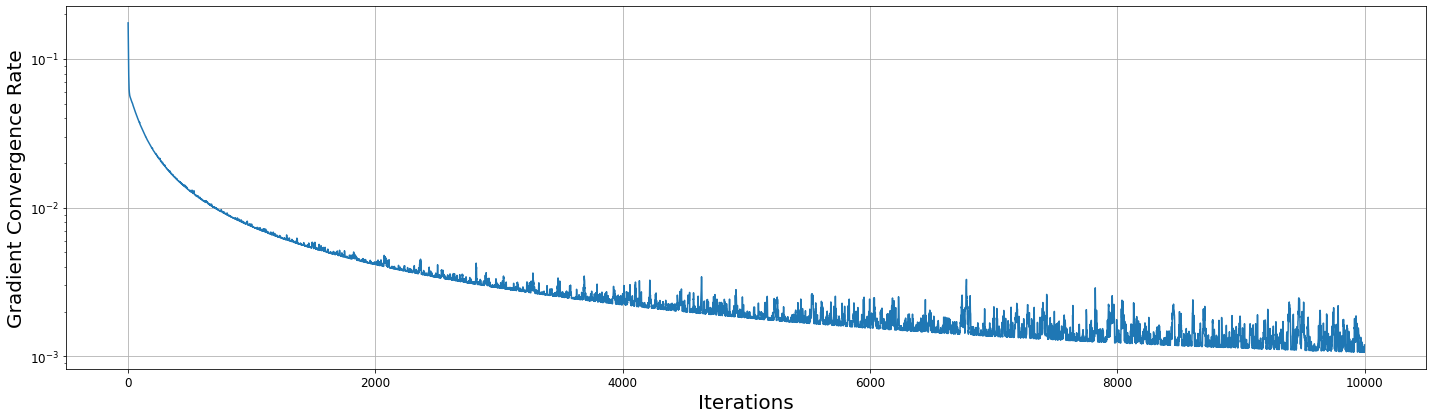

In [ ]:
import matplotlib.pyplot as plt
import random

batch_size = 512
epsilon = 1e-5
text_label_iterations = r"Iterations"
text_label_convergence_rate = r"Gradient Convergence Rate"

def analitical_grad_sgd(X, Y, WB): 

    return (sigmoid(WB, X) - Y) * X
    #return (sigmoid(WB, X) - Y).T @ X

def analitical_grad_batched(X, Y, WB):

    return (1 / X.shape[0]) *((sigmoid(WB, X) - Y).T @ X)

def batch_gradientsN(X, Y, WB, batch_size = batch_size):
    batch_indexes = np.random.randint(m, size=batch_size)

    E = 0
    for i in batch_indexes:
        E += analitical_grad_sgd(X[i], Y[i], WB)
    return E

def batch_gradients(X, Y, WB, batch_size = batch_size):
    #batch_indexes = sorted(np.random.randint(m, size=batch_size))
    #print(batch_indexes)
    batch_indexes = list(range(m))
    random.shuffle(batch_indexes)
    batch_indexes = batch_indexes[:batch_size]
    #batch_indexes.sort()

    #print(batch_indexes)
    # we will need to form X and Y to have batched number of rows
    #return analitical_grad_batched(X, Y, WB)
    
    XBatched = []
    YBatched = []
    for i in range(batch_size):
        XBatched.append(X[batch_indexes[i]])
        YBatched.append(Y[batch_indexes[i]])
    
    #print(X.shape, np.array(XBatched).shape, Y.shape, np.array(YBatched).shape)
    #print("Y", Y)
    #print("YB", YBatched)
    return analitical_grad_batched(np.array(XBatched), YBatched, WB)

def StohasticGradientDescent(WB, alpha, epsilon, max_iterations=10000):
    
    wb_history = []
    iteration = 0
    convergence_history = []
    converged = False
    for iteration in range(max_iterations):
        gradient = batch_gradients(X, Y, WB)
        WB = WB - alpha * gradient
        #convergence_history.append((m/batch_size)*np.linalg.norm(gradient))
        #convergence_history.append(np.linalg.norm(gradient))
        convergence_history.append(np.linalg.norm(analitical_grad(X, Y, WB)))

        #print(convergence_history[-1])
        '''
        if convergence_history[-1] < epsilon:
            print(f"Converged on iteration {iteration}")
            converged = True
            break
        '''
    return convergence_history, converged

max_iterations = 10000
WB = np.ones(n + 1)
alpha = 1
convergence_history, _ = StohasticGradientDescent(WB, alpha, epsilon, max_iterations=max_iterations)

plt.figure(figsize=(20,6))
plt.xlabel(text_label_iterations, fontsize=20)
plt.ylabel(text_label_convergence_rate, fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()
_ = plt.semilogy(convergence_history, label = (f"step size {alpha}"))

## Adam


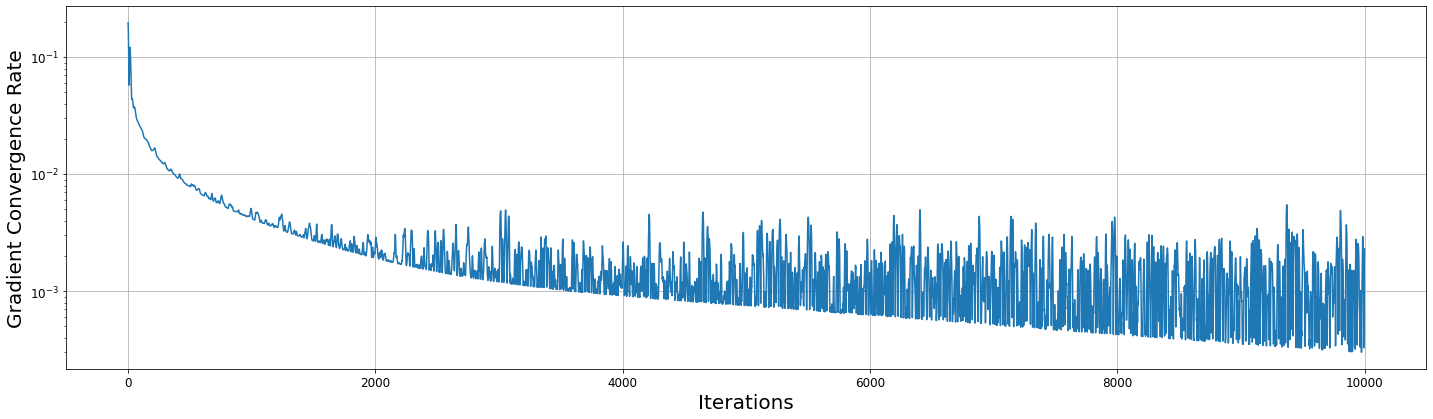

In [ ]:
import matplotlib.pyplot as plt
import random

batch_size = 512
epsilon = 1e-5
text_label_iterations = r"Iterations"
text_label_convergence_rate = r"Gradient Convergence Rate"

def analitical_grad_sgd(X, Y, WB): 

    return (sigmoid(WB, X) - Y) * X
    #return (sigmoid(WB, X) - Y).T @ X

def analitical_grad_batched(X, Y, WB):

    return (1 / X.shape[0]) *((sigmoid(WB, X) - Y).T @ X)

def batch_gradientsN(X, Y, WB, batch_size = batch_size):
    batch_indexes = np.random.randint(m, size=batch_size)

    E = 0
    for i in batch_indexes:
        E += analitical_grad_sgd(X[i], Y[i], WB)
    return E

def batch_gradients(X, Y, WB, batch_size = batch_size):
    #batch_indexes = sorted(np.random.randint(m, size=batch_size))
    #print(batch_indexes)
    batch_indexes = list(range(m))
    random.shuffle(batch_indexes)
    batch_indexes = batch_indexes[:batch_size]
    #batch_indexes.sort()

    #print(batch_indexes)
    # we will need to form X and Y to have batched number of rows
    #return analitical_grad_batched(X, Y, WB)
    
    XBatched = []
    YBatched = []
    for i in range(batch_size):
        XBatched.append(X[batch_indexes[i]])
        YBatched.append(Y[batch_indexes[i]])
    
    #print(X.shape, np.array(XBatched).shape, Y.shape, np.array(YBatched).shape)
    #print("Y", Y)
    #print("YB", YBatched)
    return analitical_grad_batched(np.array(XBatched), YBatched, WB)

def Adam(WB, alpha, epsilon, max_iterations=10000):
    
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
    p1, p2 = 0.9, 0.999 
    r, s = 0, 0
    bps = 1e-08
    eps = 0.01
    k = batch_size

    wb_history = []
    iteration = 0
    convergence_history = []
    converged = False
    for iteration in range(max_iterations):
        g = batch_gradients(X, Y, WB)
        #Adamsky
        r = p2 * r + (1 - p2) * g * g
        s = p1 * s + (1 - p1) * g
        s_ = s / (1 - p1 ** k)
        r_ = r / (1 - p2 ** k)
        h = (eps * s_)/(bps + r_ ** 0.5)
        #Adamsky

        WB = WB - alpha * h
        convergence_history.append(np.linalg.norm(analitical_grad(X, Y, WB)))

        '''
        if convergence_history[-1] < epsilon:
            print(f"Converged on iteration {iteration}")
            converged = True
            break
        '''
    return convergence_history, converged

max_iterations = 10000
WB = np.ones(n + 1)
alpha = 2.5
convergence_history, _ = Adam(WB, alpha, epsilon, max_iterations=max_iterations)

plt.figure(figsize=(20,6))
plt.xlabel(text_label_iterations, fontsize=20)
plt.ylabel(text_label_convergence_rate, fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()
_ = plt.semilogy(convergence_history, label = (f"step size {alpha}"))

### Nesterov momentum



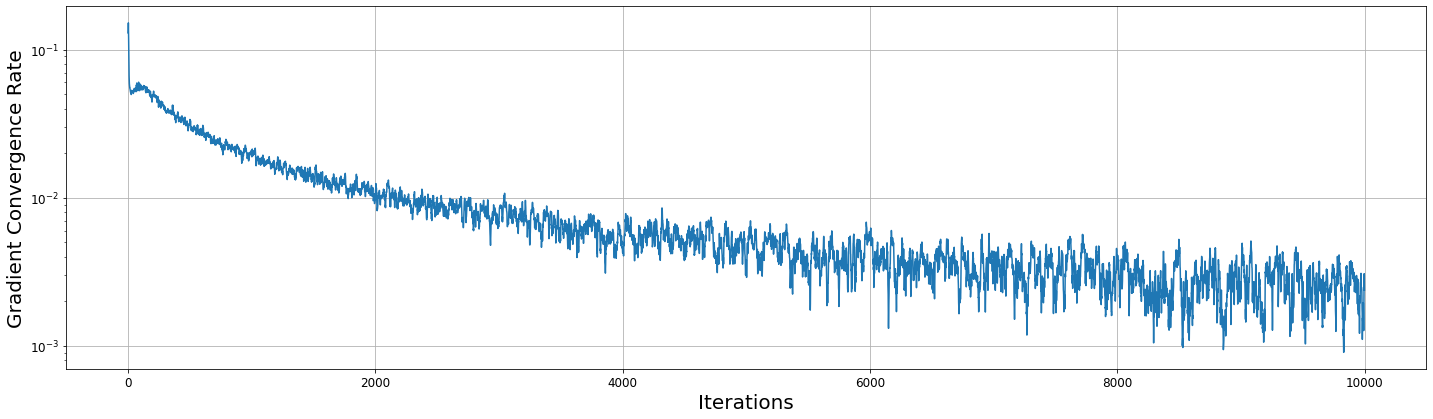

In [ ]:
import matplotlib.pyplot as plt
import random

batch_size = 512
epsilon = 1e-5
text_label_iterations = r"Iterations"
text_label_convergence_rate = r"Gradient Convergence Rate"

def analitical_grad_sgd(X, Y, WB): 

    return (sigmoid(WB, X) - Y) * X
    #return (sigmoid(WB, X) - Y).T @ X

def analitical_grad_batched(X, Y, WB):

    return (1 / X.shape[0]) *((sigmoid(WB, X) - Y).T @ X)

def batch_gradientsN(X, Y, WB, batch_size = batch_size):
    batch_indexes = np.random.randint(m, size=batch_size)

    E = 0
    for i in batch_indexes:
        E += analitical_grad_sgd(X[i], Y[i], WB)
    return E

def batch_gradients(X, Y, WB, batch_size = batch_size):
    #batch_indexes = sorted(np.random.randint(m, size=batch_size))
    #print(batch_indexes)
    batch_indexes = list(range(m))
    random.shuffle(batch_indexes)
    batch_indexes = batch_indexes[:batch_size]
    #batch_indexes.sort()

    #print(batch_indexes)
    # we will need to form X and Y to have batched number of rows
    #return analitical_grad_batched(X, Y, WB)
    
    XBatched = []
    YBatched = []
    for i in range(batch_size):
        XBatched.append(X[batch_indexes[i]])
        YBatched.append(Y[batch_indexes[i]])
    
    #print(X.shape, np.array(XBatched).shape, Y.shape, np.array(YBatched).shape)
    #print("Y", Y)
    #print("YB", YBatched)
    return analitical_grad_batched(np.array(XBatched), YBatched, WB)

def NesterovMomentum(WB, alpha, epsilon, max_iterations=10000):
    
    # 

    b = 0.3# этот параметр меняет результат!
    h = 0.9
    wb_history = []
    iteration = 0
    convergence_history = []
    converged = False
    for iteration in range(max_iterations):
        
        #Nesterov
        h = b*h - alpha*batch_gradients(X + alpha * h, Y, WB)
        WB = WB + alpha * h
        #Nesterov

        convergence_history.append(np.linalg.norm(analitical_grad(X, Y, WB)))

        '''
        if convergence_history[-1] < epsilon:
            print(f"Converged on iteration {iteration}")
            converged = True
            break
        '''
    return convergence_history, converged

max_iterations = 10000
WB = np.ones(n + 1)
alpha = 1
convergence_history, _ = NesterovMomentum(WB, alpha, epsilon, max_iterations=max_iterations)

plt.figure(figsize=(20,6))
plt.xlabel(text_label_iterations, fontsize=20)
plt.ylabel(text_label_convergence_rate, fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()
_ = plt.semilogy(convergence_history, label = (f"step size {alpha}"))

## Problem 2 (8 pts)

Consider the following optimization problem

$$
\min_x \log \left( \sum_{i=1}^m \exp(a_i^{\top}x + b_i)\right).
$$

- (2 pts) Compare convergence of gradient descent, non-linear conjugate gradient method from ```scipy.optimize``` package, heavy ball method and accelerated gradient method in solving this problem if the gradient norm is used as a measure of convergence 

- (4 pts) What procedure to select the step size gives the fastest convergence for every method? Consider any three strategies for every of the following method: gradient descent, heavy ball method and accelerated gradient method. For example, constant, decreasing sequence, some adaptive rule. In the latter case, think how you can adapt the Armijo rule (or similar rules) for heavy ball and accelerated gradient method.
- (2 pts) Consider different dimensions $m$ and $n$ ($m > n$ and $m < n$). Vectors $a_i$ and $b$ can be generated from the standard normal distribution.

Note that the stable way to compute the objective and gradient is crucial to solve this problem successfully, otherwise you will get NaN values in vector $x_k$ since the intermediate values for the sum of large exponent overflow the capacity of the ```double``` precision.

In [ ]:
# Your solution is here